In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import plotly.express as px


## Data Cleaning

In [2]:
df = pd.read_csv('C:/Users/19229/OneDrive/Desktop/data1030-fall2025/data1030-project/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape
df.head()
df.dtypes
#df = df.drop(['customerID'], axis = 1), already done

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2265.000258
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1400.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


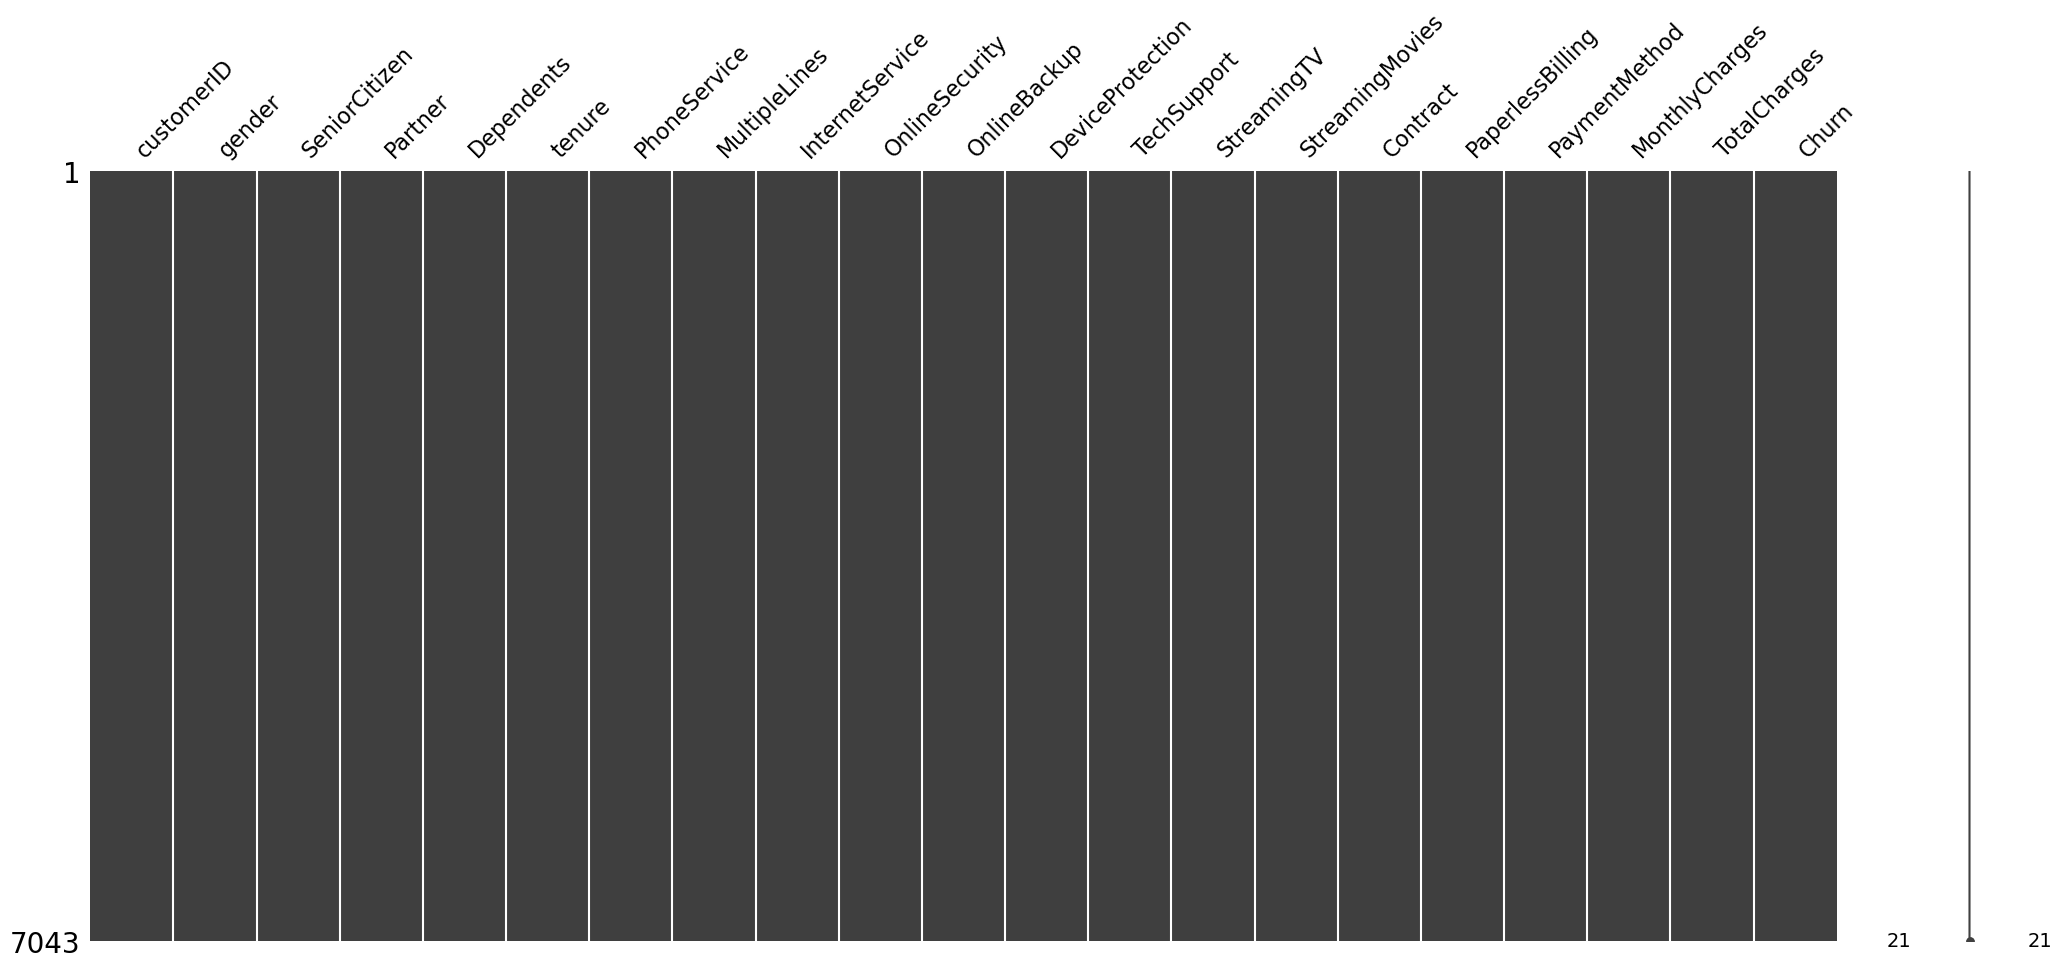

In [3]:
msno.matrix(df)
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
print(df.isnull().sum())
df[np.isnan(df['TotalCharges'])]
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())
print(df.isnull().sum())

df["SeniorCitizen"] = df["SeniorCitizen"].map({0:"No", 1:"Yes"}).astype("category") #change int to bool for onee-hot encoding
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

## EDA

In [4]:
import matplotlib.pyplot as plt
import os
plt.rcParams["figure.figsize"] = (7,4)

os.makedirs("reports/figures", exist_ok=True)

target = "Churn"

_churn_num = df[target].map({"No":0, "Yes":1})#temperory switch to 0/1 for matrix and EDA

In [5]:
print("Shape:", df.shape)
print("Missing per column after cleaning:\n", df.isna().sum()[df.isna().sum()>0])
print("Churn distribution:\n", df[target].value_counts())
print("Positive rate:", _churn_num.mean().round(3))
print("\nNumeric summary:\n", df[numerical_cols].describe().T)

Shape: (7043, 21)
Missing per column after cleaning:
 Series([], dtype: int64)
Churn distribution:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64
Positive rate: 0.265

Numeric summary:
                  count         mean          std    min      25%      50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.000    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.500    70.35   
TotalCharges    7043.0  2283.300441  2265.000258  18.80  402.225  1400.55   

                    75%      max  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80  


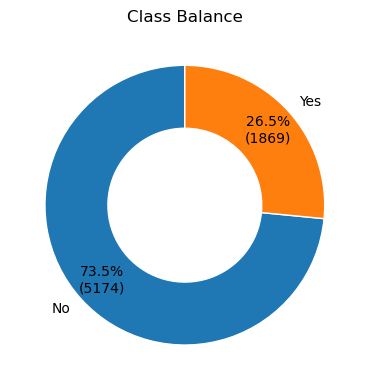

In [6]:
counts = df[target].value_counts().reindex(["No","Yes"])
labels = counts.index
vals = counts.values
total = counts.sum()

fig, ax = plt.subplots(figsize=(6,4))
ax.pie(
    vals,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p*total/100))})",
    startangle=90,
    pctdistance=0.8,
    wedgeprops={"width":0.45, "edgecolor":"white"}
)
ax.set_title("Class Balance")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

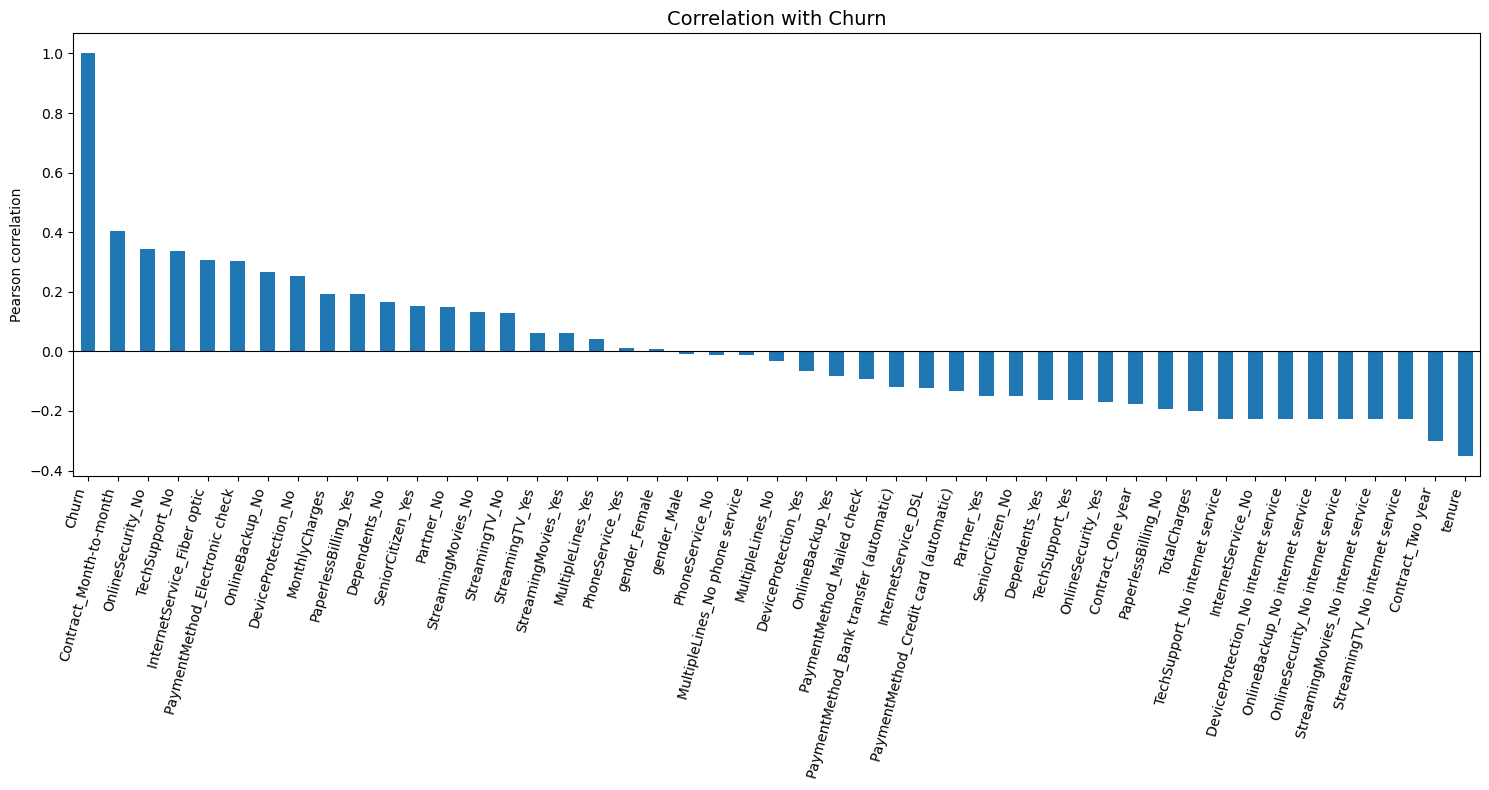

In [7]:
data = df.copy()
data["Churn"] = data["Churn"].map({"No":0, "Yes":1}).astype(int)
if "customerID" in data.columns:
    data = data.drop(columns=["customerID"])

dummies = pd.get_dummies(data, dtype=int)

y = dummies["Churn"]
X = dummies.drop(columns="Churn")
corr = X.corrwith(y)      

corr_with_target = pd.concat([pd.Series({"Churn": 1.0}), corr])

corr_sorted = corr_with_target.sort_values(ascending=False)

plt.figure(figsize=(15, 8))
corr_sorted.plot(kind="bar")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Correlation with Churn", fontsize=14)
plt.ylabel("Pearson correlation")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

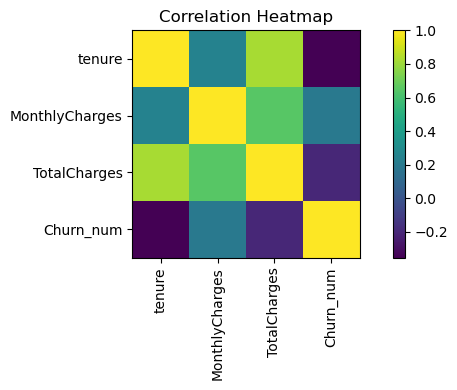

Top correlation with Churn_num:
 tenure            0.352229
TotalCharges      0.199428
MonthlyCharges    0.193356
Name: Churn_num, dtype: float64


In [8]:
corr_df = df[numerical_cols].copy()
corr_df["Churn_num"] = _churn_num
corr = corr_df.corr()

plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout(); plt.savefig("reports/figures/eda_corr_heatmap.png", dpi=200); 
plt.show()

print("Top correlation with Churn_num:\n", corr["Churn_num"].drop("Churn_num").abs().sort_values(ascending=False))

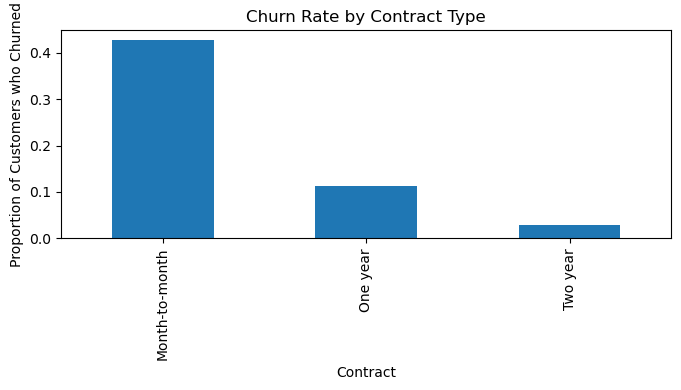

In [9]:
churn_by_contract = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()['Yes']
churn_by_contract.plot(kind='bar')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion of Customers who Churned')
plt.tight_layout(); 
plt.show()

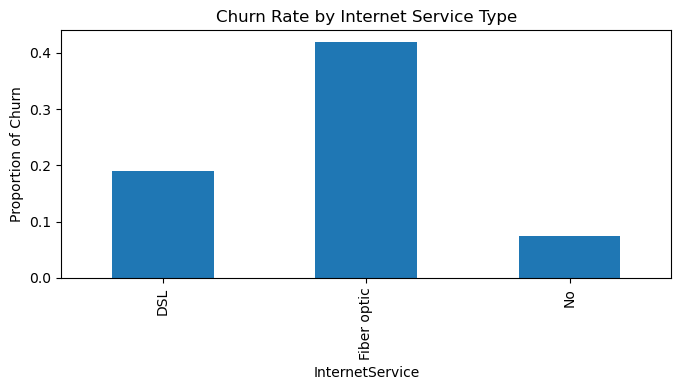

In [10]:
churn_by_service = df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()['Yes']
churn_by_service.plot(kind='bar')
plt.title('Churn Rate by Internet Service Type')
plt.ylabel('Proportion of Churn')
plt.tight_layout(); plt.show()


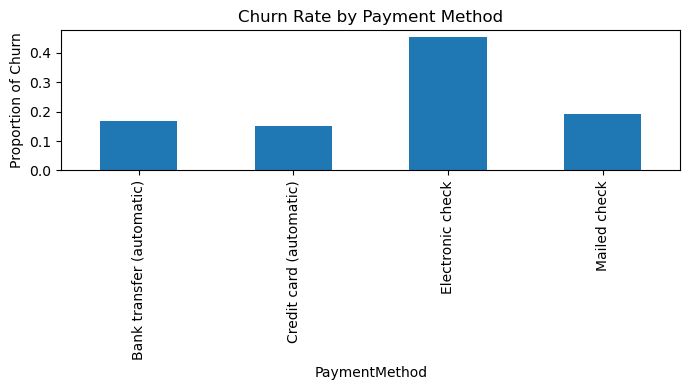

In [11]:
churn_by_payment = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack()['Yes']
churn_by_payment.plot(kind='bar')
plt.title('Churn Rate by Payment Method')
plt.ylabel('Proportion of Churn')
plt.tight_layout(); plt.show()

In [12]:
top_cat = "SeniorCitizen" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

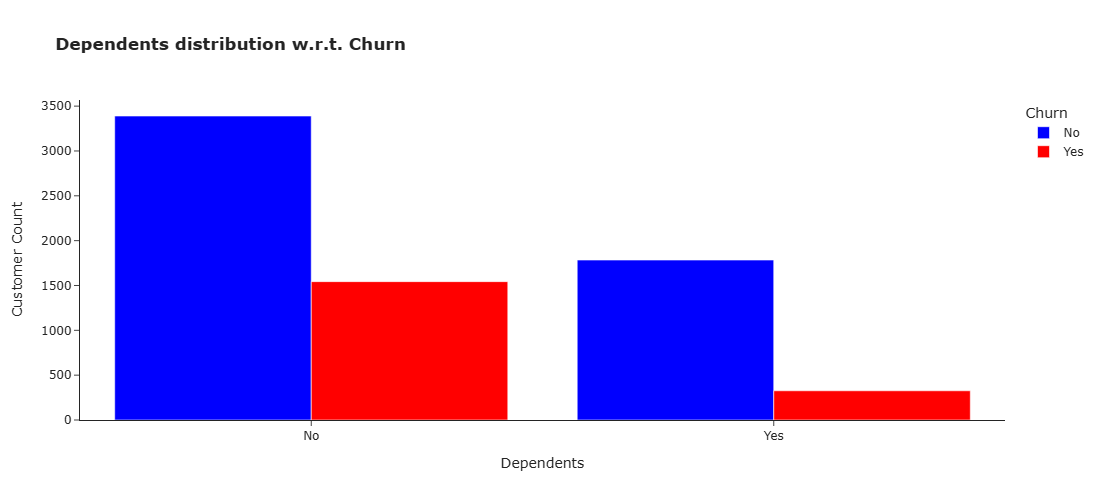

In [13]:
import plotly.express as px
top_cat = "Dependents" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

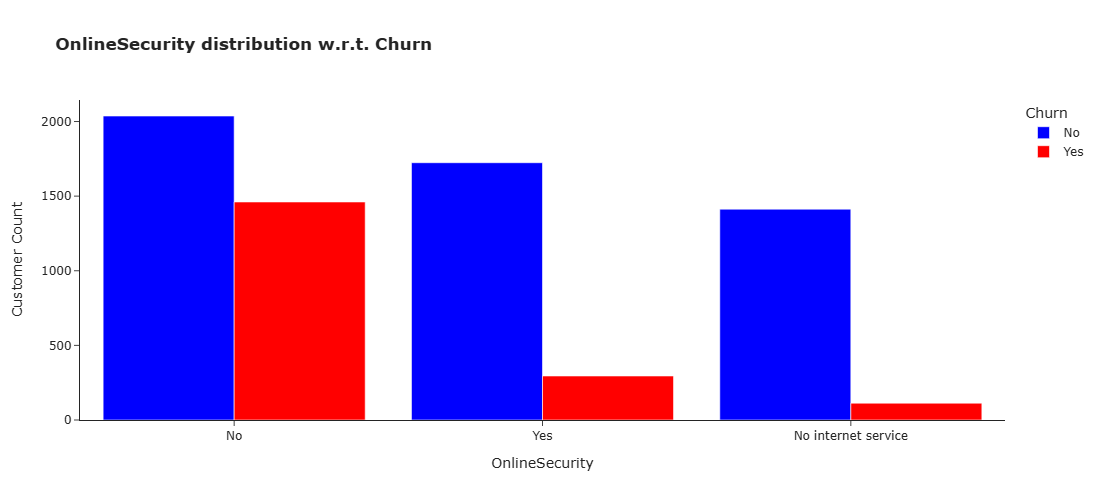

In [14]:
top_cat = "OnlineSecurity" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

In [15]:
top_cat = "TechSupport" 
color_map = {"Yes": "red", "No": "blue"}

fig = px.histogram(
    df,
    x=top_cat,
    color="Churn",
    barmode="group",
    title=f"<b>{top_cat} distribution w.r.t. Churn</b>",
    color_discrete_map=color_map
)

fig.update_layout(
    width=700,
    height=500,
    bargap=0.15,
    xaxis_title=top_cat,
    yaxis_title="Customer Count",
    legend_title="Churn",
    template="simple_white"
)

fig.show()

## Preprocessing

Train: (4225, 19), Val: (1409, 19), Test: (1409, 19)
Pos rate train/val/test: 0.265/0.265/0.265
Processed shapes: (4225, 44) (1409, 44) (1409, 44)
Total features after preprocessing: 44


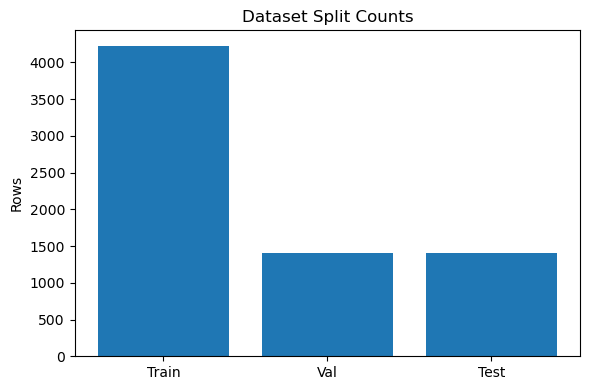

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt

y = df["Churn"].map({"No":0, "Yes":1}).astype(int)
X = df.drop(columns=["Churn","customerID"], errors="ignore")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

# define ordinal columns explicitly
ord_cols = ["Contract"]  # add more here if needed
nominal_cols = [c for c in cat_cols if c not in ord_cols]

X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=123)
X_train, X_val,  y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=123)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Pos rate train/val/test: {y_train.mean():.3f}/{y_val.mean():.3f}/{y_test.mean():.3f}")

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

ordinal_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[["Month-to-month", "One year", "Two year"]]))
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("ord", ordinal_pipe, ord_cols),
    ("cat", categorical_pipe, nominal_cols)
])

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
ohe_names = ohe.get_feature_names_out(nominal_cols)

feature_names = np.r_[num_cols, ord_cols, ohe_names]

print("Processed shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)
print("Total features after preprocessing:", len(feature_names))

sizes = {"Train": len(X_train), "Val": len(X_val), "Test": len(X_test)}
plt.figure(figsize=(6,4))
plt.bar(list(sizes.keys()), list(sizes.values()))
plt.title("Dataset Split Counts")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()



BASELINE ACCURACY (predict majority class): 0.7347

Training Logistic Regression...
  Best params: {'C': 10.0, 'solver': 'lbfgs'}
  CV AUC: 0.8406 +- 0.0134
  Test AUC: 0.8438 +- 0.0000

Training Decision Tree...
  Best params: {'max_depth': 5, 'min_samples_split': 20}
  CV AUC: 0.8212 +- 0.0103
  Test AUC: 0.8183 +- 0.0000

Training Random Forest...
  Best params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 20}
  CV AUC: 0.8401 +- 0.0138
  Test AUC: 0.8403 +- 0.0013

Training Gradient Boosting...
  Best params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
  CV AUC: 0.8434 +- 0.0143
  Test AUC: 0.8428 +- 0.0000
MODEL PERFORMANCE SUMMARY
              Model                                                    Best Params        CV AUC  Test Accuracy  Test Precision  Test Recall  Test F1  Test AUC Test AUC(mean,std)
Logistic Regression                                 {'C': 10.0, 'solver': 'lbfgs'} 0.8406±0.0134       0.800568        0.653465     0.529412 0.5849

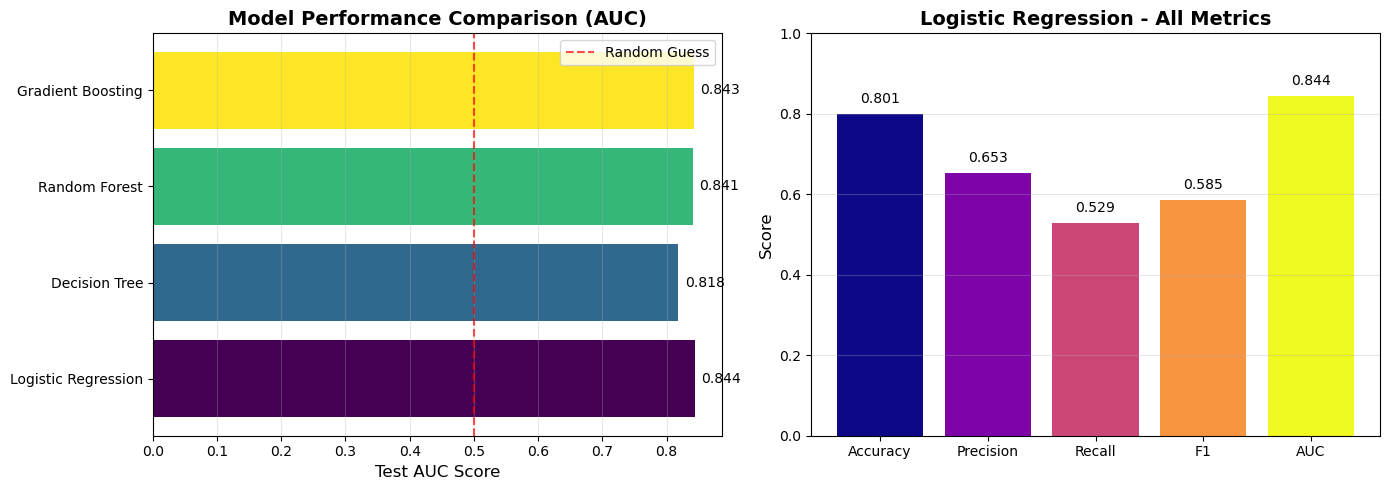

FEATURE IMPORTANCE ANALYSIS

 Permutation Importance

Top 10 Features (Permutation Importance):
                       Feature  Importance      Std
                        tenure    0.115614 0.005708
                MonthlyCharges    0.072676 0.012066
                  TotalCharges    0.024911 0.003748
   InternetService_Fiber optic    0.022569 0.007306
                      Contract    0.020369 0.004600
           InternetService_DSL    0.012562 0.005964
                 gender_Female    0.004613 0.001530
           PaperlessBilling_No    0.004187 0.003425
             MultipleLines_Yes    0.003194 0.002402
PaymentMethod_Electronic check    0.002768 0.002019


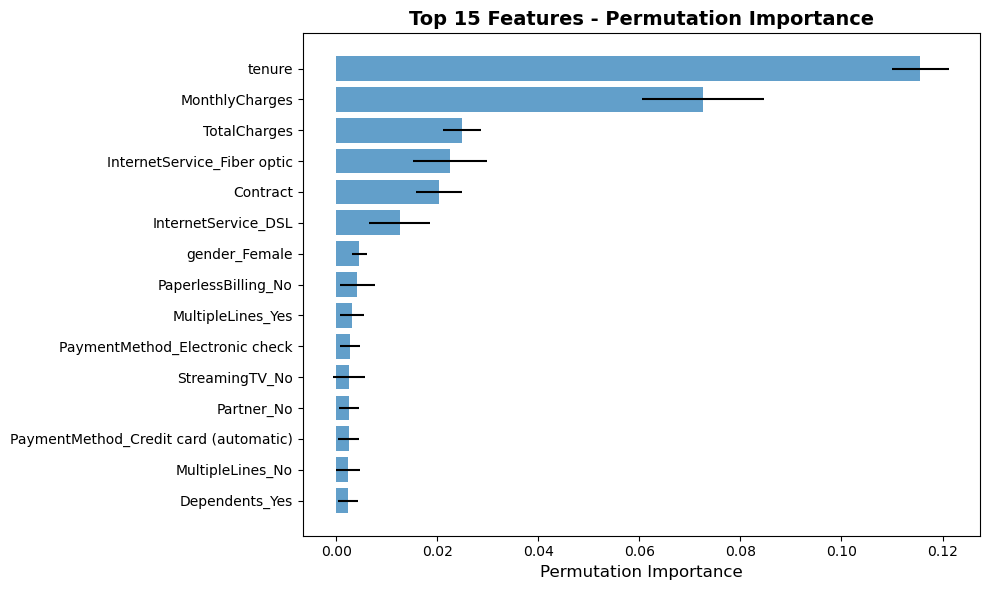


Top 10 Features (Coefficient Magnitude - Logistic Regression):
                           Feature  Importance
                            tenure    1.440225
                    MonthlyCharges    1.231176
       InternetService_Fiber optic    0.954166
               InternetService_DSL    0.823253
                      TotalCharges    0.785174
                          Contract    0.738834
               StreamingMovies_Yes    0.431555
OnlineSecurity_No internet service    0.391934
                InternetService_No    0.391934
   TechSupport_No internet service    0.391934


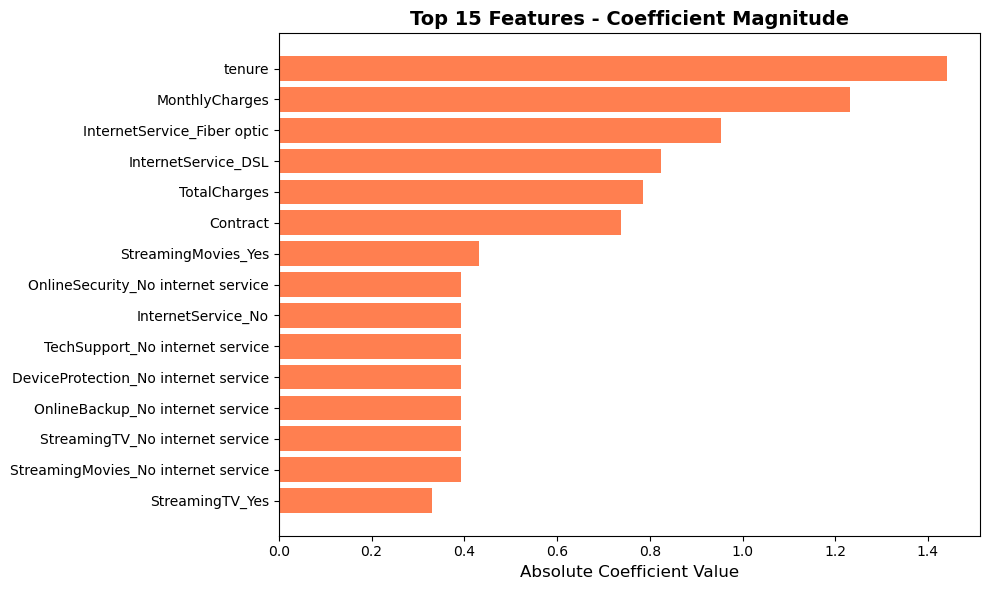

SHAP ANALYSIS


  0%|          | 0/100 [00:00<?, ?it/s]

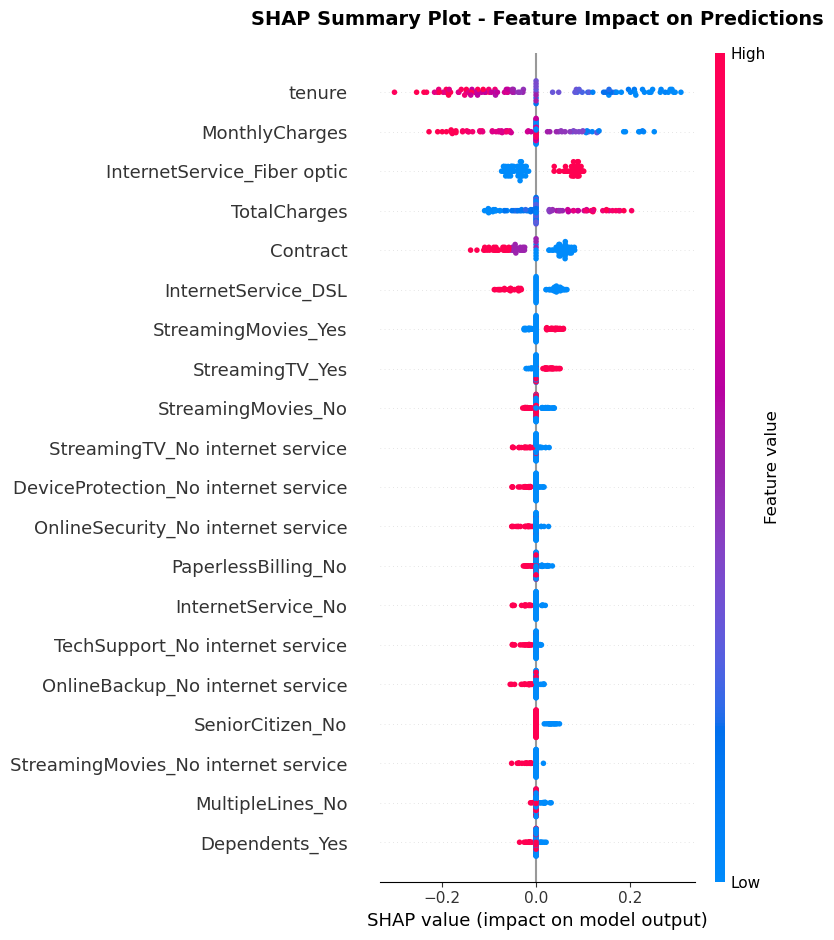

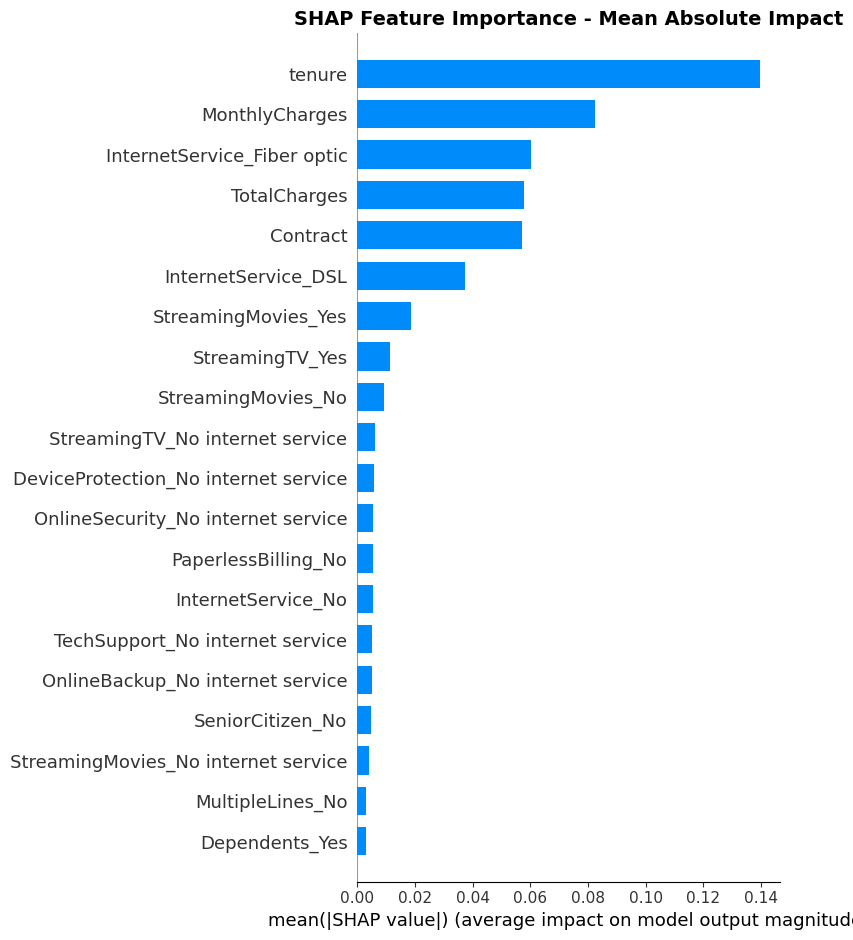

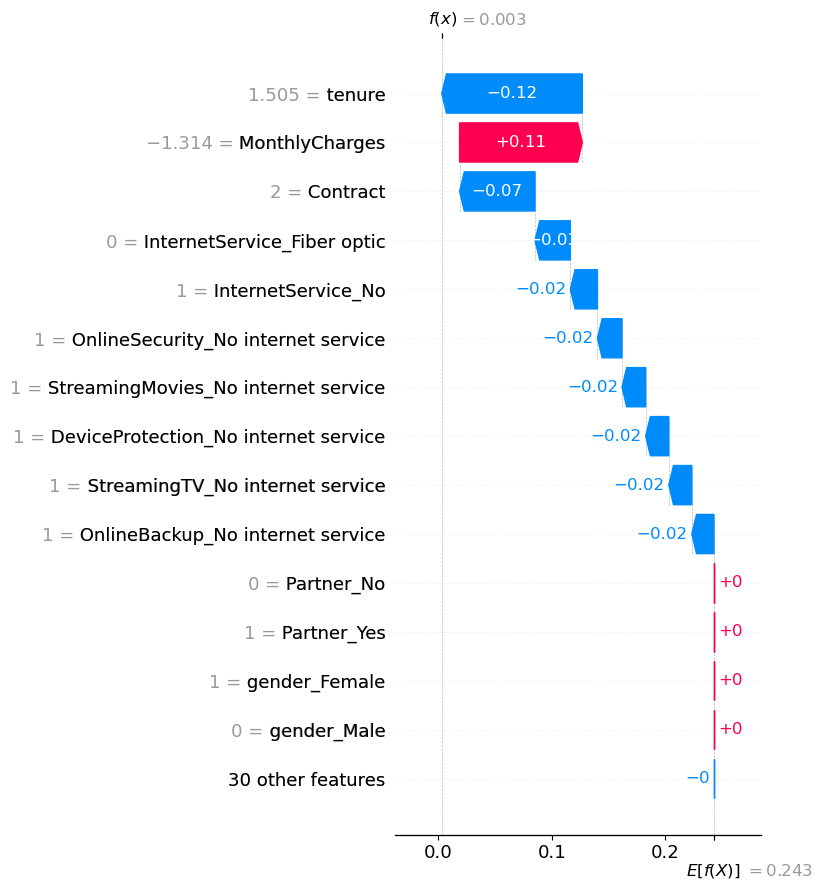


Key Findings:
1. Best Model: Logistic Regression
2. Test AUC: 0.8438
3. Performance is 0.15 std above baseline
4. Most important features identified through multiple methods
5. SHAP analysis provides local explanations for individual predictions


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

#global figure settings 
os.makedirs("figures", exist_ok=True)
plt.rcParams["savefig.dpi"] = 300


# Model Training

# Baseline: predict majority class
baseline_accuracy = 1 - y_train.mean()  # Assuming no churn is majority
print(f"BASELINE ACCURACY (predict majority class): {baseline_accuracy:.4f}")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=123)
}

param_grids = {
    "Logistic Regression": [
        {"C": 0.01, "solver": "lbfgs"},
        {"C": 0.1, "solver": "lbfgs"},
        {"C": 1.0, "solver": "lbfgs"},
        {"C": 10.0, "solver": "lbfgs"}
    ],
    "Decision Tree": [
        {"max_depth": 5, "min_samples_split": 20},
        {"max_depth": 10, "min_samples_split": 20},
        {"max_depth": 15, "min_samples_split": 10},
        {"max_depth": None, "min_samples_split": 10}
    ],
    "Random Forest": [
        {"n_estimators": 50, "max_depth": 10, "min_samples_split": 20},
        {"n_estimators": 100, "max_depth": 15, "min_samples_split": 10},
        {"n_estimators": 200, "max_depth": 20, "min_samples_split": 5}
    ],
    "Gradient Boosting": [
        {"n_estimators": 50, "learning_rate": 0.1, "max_depth": 3},
        {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3},
        {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 5}
    ]
}


# Training and Evaluation

results = []
best_models = {}

for model_name, base_model in models.items():
    print(f"\nTraining {model_name}...")
    
    best_score = 0
    best_params = None
    best_model_instance = None

    for params in param_grids[model_name]:
        model = base_model.__class__(**params, random_state=123)
        model.fit(X_train_p, y_train)
        val_score = roc_auc_score(y_val, model.predict_proba(X_val_p)[:, 1])
        
        if val_score > best_score:
            best_score = val_score
            best_params = params
            best_model_instance = model

    cv_scores = cross_val_score(
        best_model_instance, X_train_p, y_train, 
        cv=5, scoring='roc_auc', n_jobs=-1
    )

    test_scores = []
    if model_name in ["Random Forest", "Gradient Boosting"]:
        for seed in range(123, 128):  
            temp_model = best_model_instance.__class__(**best_params, random_state=seed)
            temp_model.fit(X_train_p, y_train)
            test_pred_proba = temp_model.predict_proba(X_test_p)[:, 1]
            test_scores.append(roc_auc_score(y_test, test_pred_proba))
    else:
        test_pred_proba = best_model_instance.predict_proba(X_test_p)[:, 1]
        test_scores = [roc_auc_score(y_test, test_pred_proba)]

    y_test_pred = best_model_instance.predict(X_test_p)
    y_test_proba = best_model_instance.predict_proba(X_test_p)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    results.append({
        "Model": model_name,
        "Best Params": str(best_params),
        "CV AUC": f"{cv_scores.mean():.4f}±{cv_scores.std():.4f}",
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
        "Test AUC": test_auc,
        "Test AUC(mean,std)": f"{np.mean(test_scores):.4f}+-{np.std(test_scores):.4f}"
    })
    
    best_models[model_name] = best_model_instance
    
    print(f"  Best params: {best_params}")
    print(f"  CV AUC: {cv_scores.mean():.4f} +- {cv_scores.std():.4f}")
    print(f"  Test AUC: {np.mean(test_scores):.4f} +- {np.std(test_scores):.4f}")


# Performance Comparison Table

results_df = pd.DataFrame(results)

print("MODEL PERFORMANCE SUMMARY")
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.loc[results_df["Test AUC"].idxmax(), "Model"]
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name} (Test AUC: {results_df['Test AUC'].max():.4f})")

best_accuracy = results_df.loc[results_df["Test AUC"].idxmax(), "Test Accuracy"]
std_above_baseline = (best_accuracy - baseline_accuracy) / (baseline_accuracy * (1 - baseline_accuracy))**0.5
print(f"Best model is {std_above_baseline:.2f} standard deviations above baseline\n")


# Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
ax1 = axes[0]
models_list = results_df["Model"].tolist()
auc_scores = results_df["Test AUC"].tolist()
colors = plt.cm.viridis(np.linspace(0, 1, len(models_list)))

bars = ax1.barh(models_list, auc_scores, color=colors)
ax1.axvline(x=0.5, color='red', linestyle='--', label='Random Guess', alpha=0.7)
ax1.set_xlabel('Test AUC Score', fontsize=12)
ax1.set_title('Model Performance Comparison (AUC)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
for i, (bar, score) in enumerate(zip(bars, auc_scores)):
    ax1.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=10)

# Multiple metrics for best model
ax2 = axes[1]
best_idx = results_df["Test AUC"].idxmax()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
values = [
    results_df.loc[best_idx, 'Test Accuracy'],
    results_df.loc[best_idx, 'Test Precision'],
    results_df.loc[best_idx, 'Test Recall'],
    results_df.loc[best_idx, 'Test F1'],
    results_df.loc[best_idx, 'Test AUC']
]
colors2 = plt.cm.plasma(np.linspace(0, 1, len(metrics)))
bars2 = ax2.bar(metrics, values, color=colors2)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title(f'{best_model_name} - All Metrics', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("figures/model_performance.png", bbox_inches="tight")
plt.show()

# Feature Importance (3+ Methods)

print("FEATURE IMPORTANCE ANALYSIS")

# Built-in feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_builtin = best_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_builtin
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Features (Built-in Importance):")
    print(feature_imp_df.head(10).to_string(index=False))
    print()

    plt.figure(figsize=(10, 6))
    top_n = 15
    top_features = feature_imp_df.head(top_n)
    plt.barh(range(top_n), top_features['Importance'].values)
    plt.yticks(range(top_n), top_features['Feature'].values)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top {top_n} Features - Built-in Importance ({best_model_name})', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("figures/feature_importance_builtin.png", bbox_inches="tight")
    plt.show()

# Permutation Importance
print("\n Permutation Importance")
perm_importance = permutation_importance(
    best_model, X_test_p, y_test, 
    n_repeats=10, random_state=123, n_jobs=-1
)

perm_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features (Permutation Importance):")
print(perm_imp_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
top_n = 15
top_features_perm = perm_imp_df.head(top_n)
y_pos = range(top_n)
plt.barh(y_pos, top_features_perm['Importance'].values, 
         xerr=top_features_perm['Std'].values, alpha=0.7)
plt.yticks(y_pos, top_features_perm['Feature'].values)
plt.xlabel('Permutation Importance', fontsize=12)
plt.title(f'Top {top_n} Features - Permutation Importance', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/feature_importance_permutation.png", bbox_inches="tight")
plt.show()

# Coefficients for Logistic Regression or alternative method
if "Logistic" in best_model_name:
    coef_importance = np.abs(best_models["Logistic Regression"].coef_[0])
    coef_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coef_importance
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Features (Coefficient Magnitude - Logistic Regression):")
    print(coef_imp_df.head(10).to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    top_n = 15
    top_features_coef = coef_imp_df.head(top_n)
    plt.barh(range(top_n), top_features_coef['Importance'].values, color='coral')
    plt.yticks(range(top_n), top_features_coef['Feature'].values)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Features - Coefficient Magnitude', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("figures/feature_importance_coefficients.png", bbox_inches="tight")
    plt.show()

# SHAP Values for Local Interpretability

print("SHAP ANALYSIS")

if best_model_name in ["Random Forest", "Gradient Boosting", "Decision Tree"]:
    X_shap = X_test_p
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_shap)
else:
    X_shap = X_test_p[:100]  
    background = shap.sample(X_train_p, 100)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)
    shap_values = explainer.shap_values(X_shap)

shap_values_arr = np.array(shap_values)

if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]  
    base_val = explainer.expected_value[1]
else:
    if shap_values_arr.ndim == 3:
        shap_values_plot = shap_values_arr[:, :, 1]
        if hasattr(explainer.expected_value, "__len__"):
            base_val = explainer.expected_value[1]
        else:
            base_val = explainer.expected_value
    else:
        shap_values_plot = shap_values_arr
        if hasattr(explainer.expected_value, "__len__"):
            base_val = explainer.expected_value[1]
        else:
            base_val = explainer.expected_value

if hasattr(X_shap, "toarray"):
    X_shap_plot = X_shap.toarray()
else:
    X_shap_plot = X_shap

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_plot,
    X_shap_plot,
    feature_names=feature_names,
    show=False
)
plt.title(
    'SHAP Summary Plot - Feature Impact on Predictions',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.tight_layout()
plt.savefig("figures/shap_summary.png", bbox_inches="tight")
plt.show()

# SHAP Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_plot,
    X_shap_plot,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title(
    'SHAP Feature Importance - Mean Absolute Impact',
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout()
plt.savefig("figures/shap_importance.png", bbox_inches="tight")
plt.show()

# waterfall plot for a single instance

sample_idx = 0

sample_data = X_shap[sample_idx]
if hasattr(sample_data, "toarray"):
    sample_data = sample_data.toarray().ravel()

values_1d = shap_values_plot[sample_idx]

shap_expl = shap.Explanation(
    values=values_1d,
    base_values=base_val,
    data=sample_data,
    feature_names=feature_names
)

plt.figure(figsize=(10, 6))          
shap.plots.waterfall(
    shap_expl,
    max_display=15,
    show=False                    
)
plt.tight_layout()
plt.savefig("figures/shap_waterfall.png", bbox_inches="tight")
plt.show()


print("\nKey Findings:")
print(f"1. Best Model: {best_model_name}")
print(f"2. Test AUC: {results_df['Test AUC'].max():.4f}")
print(f"3. Performance is {std_above_baseline:.2f} std above baseline")
print(f"4. Most important features identified through multiple methods")
print(f"5. SHAP analysis provides local explanations for individual predictions")


BASELINE ACCURACY (predict majority class): 0.7347

Training Logistic Regression...
  Best params: {'C': 10.0, 'solver': 'lbfgs'}
  CV AUC: 0.8406 +- 0.0134
  Test AUC: 0.8438 +- 0.0000

Training Decision Tree...
  Best params: {'max_depth': 5, 'min_samples_split': 20}
  CV AUC: 0.8212 +- 0.0103
  Test AUC: 0.8183 +- 0.0000

Training Random Forest...
  Best params: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 20}
  CV AUC: 0.8401 +- 0.0138
  Test AUC: 0.8403 +- 0.0013

Training Gradient Boosting...
  Best params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
  CV AUC: 0.8434 +- 0.0143
  Test AUC: 0.8428 +- 0.0000
MODEL PERFORMANCE SUMMARY
              Model                                                    Best Params  CV AUC Mean  CV AUC Std        CV AUC  Test Accuracy  Test Precision  Test Recall  Test F1  Test AUC  Test AUC Std Test AUC(mean,std)
Logistic Regression                                 {'C': 10.0, 'solver': 'lbfgs'}     0.840628    0.013447 

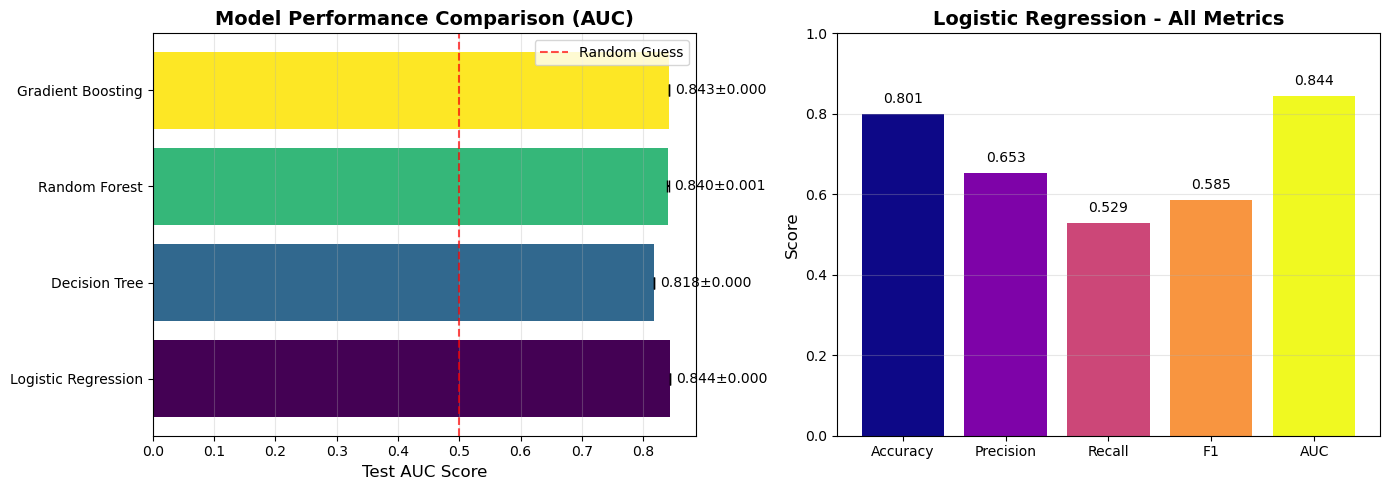

FEATURE IMPORTANCE ANALYSIS

 Permutation Importance

Top 10 Features (Permutation Importance):
                       Feature  Importance      Std
                        tenure    0.115614 0.005708
                MonthlyCharges    0.072676 0.012066
                  TotalCharges    0.024911 0.003748
   InternetService_Fiber optic    0.022569 0.007306
                      Contract    0.020369 0.004600
           InternetService_DSL    0.012562 0.005964
                 gender_Female    0.004613 0.001530
           PaperlessBilling_No    0.004187 0.003425
             MultipleLines_Yes    0.003194 0.002402
PaymentMethod_Electronic check    0.002768 0.002019


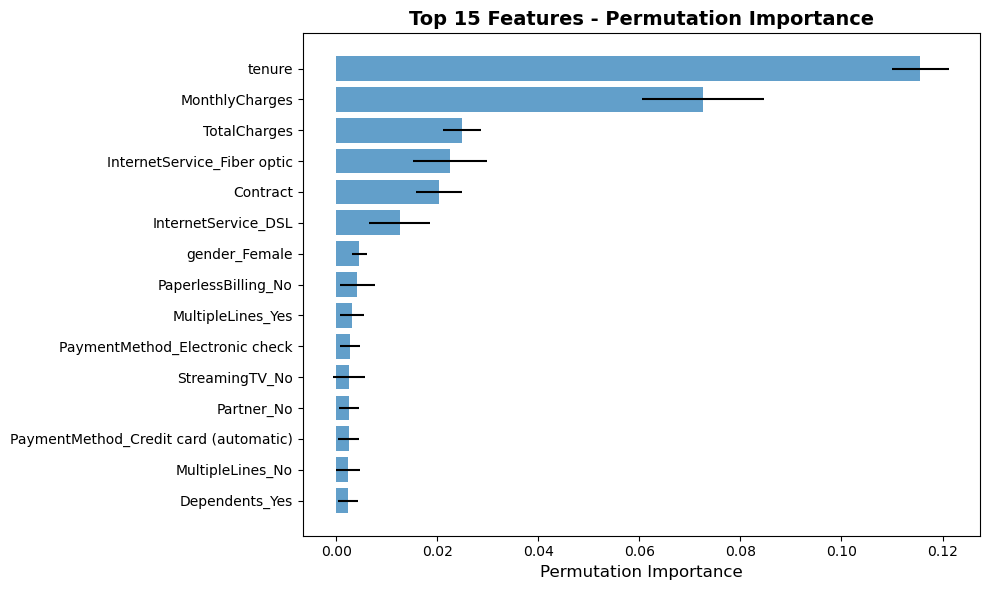


Top 10 Features (Coefficient Magnitude - Logistic Regression):
                           Feature  Importance
                            tenure    1.440225
                    MonthlyCharges    1.231176
       InternetService_Fiber optic    0.954166
               InternetService_DSL    0.823253
                      TotalCharges    0.785174
                          Contract    0.738834
               StreamingMovies_Yes    0.431555
OnlineSecurity_No internet service    0.391934
                InternetService_No    0.391934
   TechSupport_No internet service    0.391934


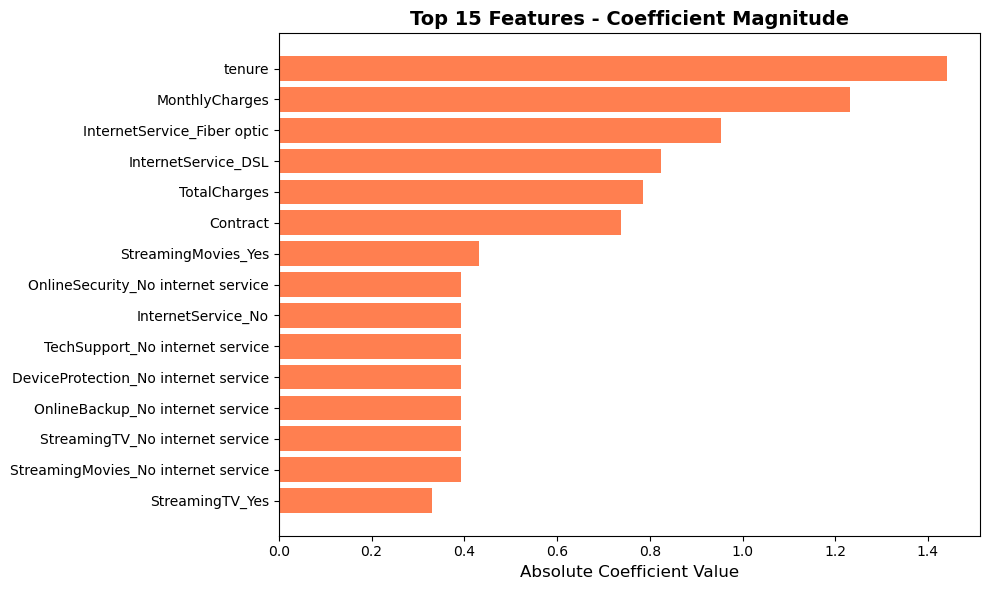

SHAP ANALYSIS


  0%|          | 0/100 [00:00<?, ?it/s]

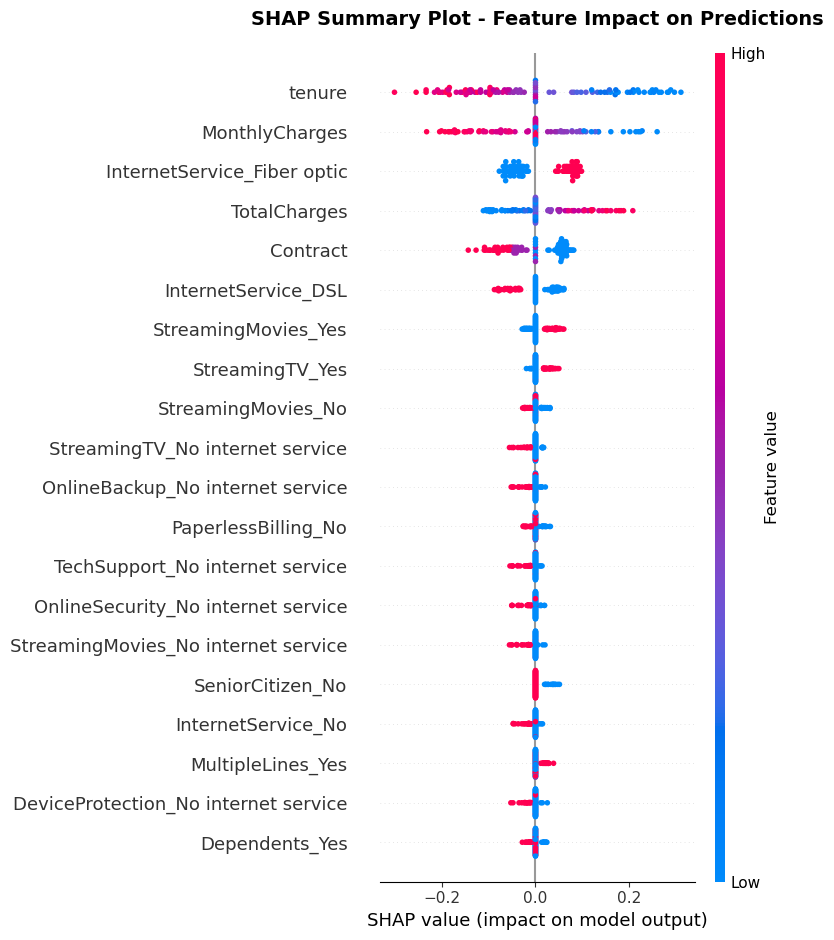

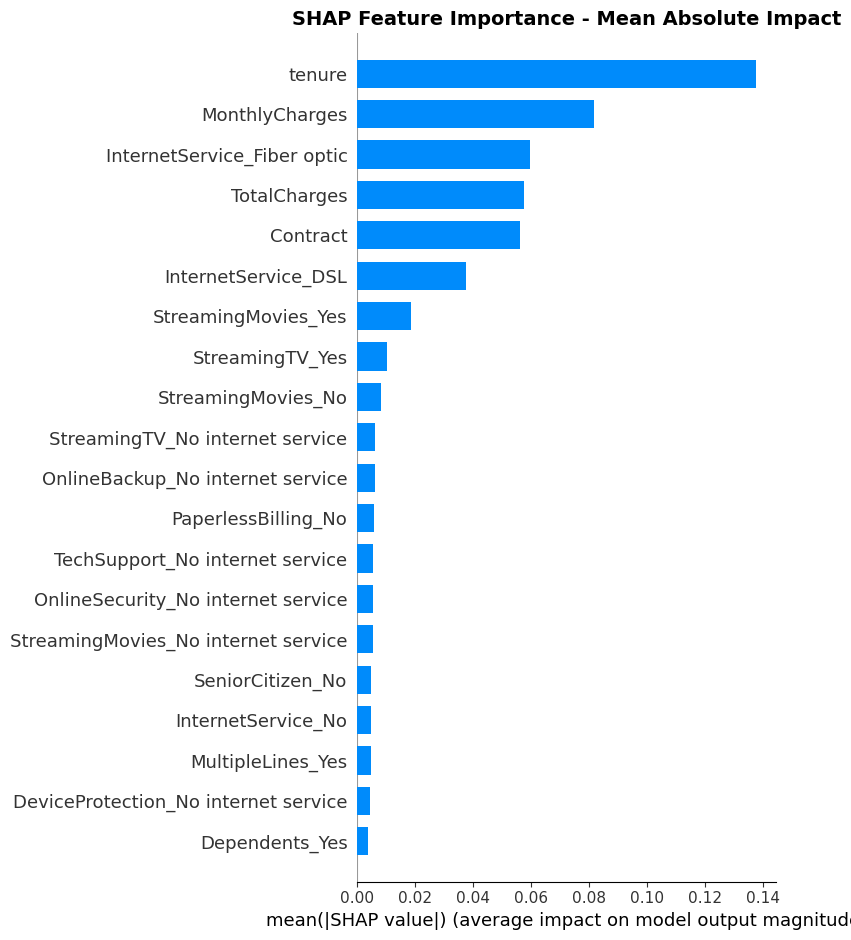

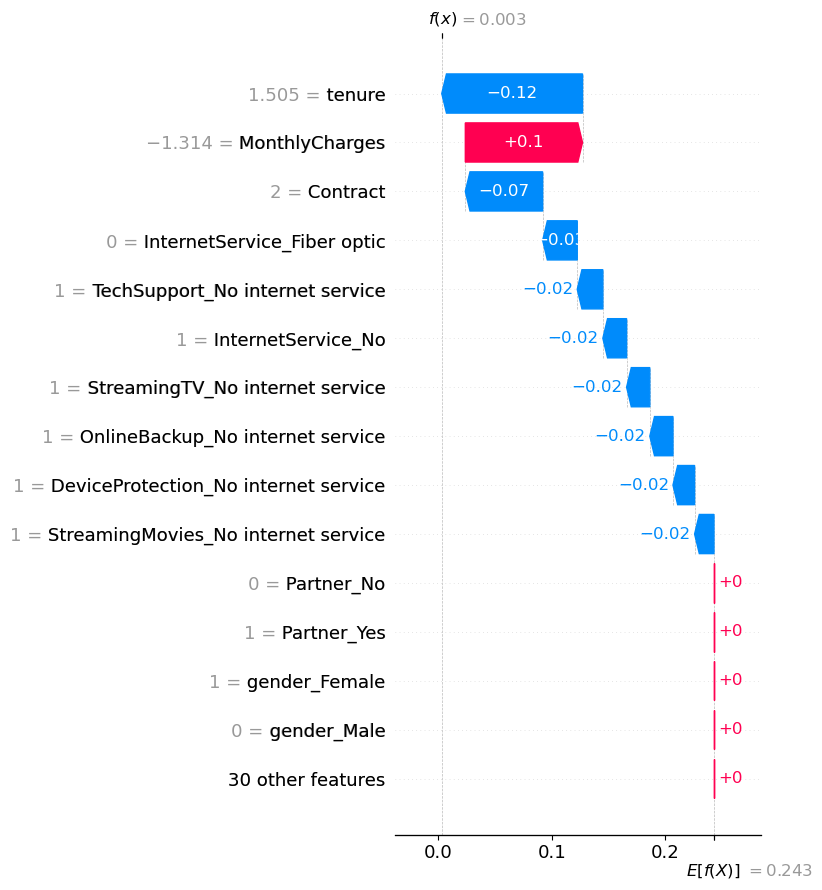


Key Findings:
1. Best Model: Logistic Regression
2. Test AUC: 0.8438
3. Performance is 0.15 std above baseline
4. Most important features identified through multiple methods
5. SHAP analysis provides local explanations for individual predictions


In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

#global figure settings 
os.makedirs("figures", exist_ok=True)
plt.rcParams["savefig.dpi"] = 300


# Model Training

# Baseline: predict majority class
baseline_accuracy = 1 - y_train.mean()  # Assuming no churn is majority
print(f"BASELINE ACCURACY (predict majority class): {baseline_accuracy:.4f}")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=123)
}

param_grids = {
    "Logistic Regression": [
        {"C": 0.01, "solver": "lbfgs"},
        {"C": 0.1, "solver": "lbfgs"},
        {"C": 1.0, "solver": "lbfgs"},
        {"C": 10.0, "solver": "lbfgs"}
    ],
    "Decision Tree": [
        {"max_depth": 5, "min_samples_split": 20},
        {"max_depth": 10, "min_samples_split": 20},
        {"max_depth": 15, "min_samples_split": 10},
        {"max_depth": None, "min_samples_split": 10}
    ],
    "Random Forest": [
        {"n_estimators": 50, "max_depth": 10, "min_samples_split": 20},
        {"n_estimators": 100, "max_depth": 15, "min_samples_split": 10},
        {"n_estimators": 200, "max_depth": 20, "min_samples_split": 5}
    ],
    "Gradient Boosting": [
        {"n_estimators": 50, "learning_rate": 0.1, "max_depth": 3},
        {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3},
        {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 5}
    ]
}


# Training and Evaluation

results = []
best_models = {}

for model_name, base_model in models.items():
    print(f"\nTraining {model_name}...")
    
    best_score = 0
    best_params = None
    best_model_instance = None

    for params in param_grids[model_name]:
        model = base_model.__class__(**params, random_state=123)
        model.fit(X_train_p, y_train)
        val_score = roc_auc_score(y_val, model.predict_proba(X_val_p)[:, 1])
        
        if val_score > best_score:
            best_score = val_score
            best_params = params
            best_model_instance = model

    cv_scores = cross_val_score(
        best_model_instance, X_train_p, y_train, 
        cv=5, scoring='roc_auc', n_jobs=-1
    )

    test_scores = []
    if model_name in ["Random Forest", "Gradient Boosting"]:
        for seed in range(123, 128):  
            temp_model = best_model_instance.__class__(**best_params, random_state=seed)
            temp_model.fit(X_train_p, y_train)
            test_pred_proba = temp_model.predict_proba(X_test_p)[:, 1]
            test_scores.append(roc_auc_score(y_test, test_pred_proba))
    else:
        test_pred_proba = best_model_instance.predict_proba(X_test_p)[:, 1]
        test_scores = [roc_auc_score(y_test, test_pred_proba)]

    y_test_pred = best_model_instance.predict(X_test_p)
    y_test_proba = best_model_instance.predict_proba(X_test_p)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc_mean = np.mean(test_scores)
    test_auc_std = np.std(test_scores)
    cv_auc_mean = cv_scores.mean()
    cv_auc_std = cv_scores.std()
    
    results.append({
        "Model": model_name,
        "Best Params": str(best_params),
        "CV AUC Mean": cv_auc_mean,
        "CV AUC Std": cv_auc_std,
        "CV AUC": f"{cv_auc_mean:.4f}±{cv_auc_std:.4f}",
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
        "Test AUC": test_auc_mean,
        "Test AUC Std": test_auc_std,
        "Test AUC(mean,std)": f"{test_auc_mean:.4f}±{test_auc_std:.4f}"
    })
    
    best_models[model_name] = best_model_instance
    
    print(f"  Best params: {best_params}")
    print(f"  CV AUC: {cv_auc_mean:.4f} +- {cv_auc_std:.4f}")
    print(f"  Test AUC: {test_auc_mean:.4f} +- {test_auc_std:.4f}")


# Performance Comparison Table

results_df = pd.DataFrame(results)

print("MODEL PERFORMANCE SUMMARY")
print(results_df.to_string(index=False))

summary_table = results_df[[
    "Model",
    "CV AUC Mean", "CV AUC Std",
    "Test AUC", "Test AUC Std"
]]
print("\nSUMMARY TABLE (MEAN / STD)")
print(summary_table.to_string(index=False))

best_model_name = results_df.loc[results_df["Test AUC"].idxmax(), "Model"]
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name} (Test AUC: {results_df['Test AUC'].max():.4f})")

best_accuracy = results_df.loc[results_df["Test AUC"].idxmax(), "Test Accuracy"]
std_above_baseline = (best_accuracy - baseline_accuracy) / (baseline_accuracy * (1 - baseline_accuracy))**0.5
print(f"Best model is {std_above_baseline:.2f} standard deviations above baseline\n")


# Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
ax1 = axes[0]
models_list = results_df["Model"].tolist()
auc_scores = results_df["Test AUC"].values
auc_stds = results_df["Test AUC Std"].values
colors = plt.cm.viridis(np.linspace(0, 1, len(models_list)))

bars = ax1.barh(models_list, auc_scores, xerr=auc_stds, color=colors, capsize=4)
ax1.axvline(x=0.5, color='red', linestyle='--', label='Random Guess', alpha=0.7)
ax1.set_xlabel('Test AUC Score', fontsize=12)
ax1.set_title('Model Performance Comparison (AUC)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
for i, (bar, mean, std) in enumerate(zip(bars, auc_scores, auc_stds)):
    ax1.text(mean + 0.01, i, f'{mean:.3f}±{std:.3f}', va='center', fontsize=10)

ax2 = axes[1]
best_idx = results_df["Test AUC"].idxmax()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
values = [
    results_df.loc[best_idx, 'Test Accuracy'],
    results_df.loc[best_idx, 'Test Precision'],
    results_df.loc[best_idx, 'Test Recall'],
    results_df.loc[best_idx, 'Test F1'],
    results_df.loc[best_idx, 'Test AUC']
]
colors2 = plt.cm.plasma(np.linspace(0, 1, len(metrics)))
bars2 = ax2.bar(metrics, values, color=colors2)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title(f'{best_model_name} - All Metrics', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("figures/model_performance.png", bbox_inches="tight")
plt.show()

# Feature Importance (3+ Methods)

print("FEATURE IMPORTANCE ANALYSIS")

# Built-in feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_builtin = best_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_builtin
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Features (Built-in Importance):")
    print(feature_imp_df.head(10).to_string(index=False))
    print()

    plt.figure(figsize=(10, 6))
    top_n = 15
    top_features = feature_imp_df.head(top_n)
    plt.barh(range(top_n), top_features['Importance'].values)
    plt.yticks(range(top_n), top_features['Feature'].values)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top {top_n} Features - Built-in Importance ({best_model_name})', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("figures/feature_importance_builtin.png", bbox_inches="tight")
    plt.show()

# Permutation Importance
print("\n Permutation Importance")
perm_importance = permutation_importance(
    best_model, X_test_p, y_test, 
    n_repeats=10, random_state=123, n_jobs=-1
)

perm_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features (Permutation Importance):")
print(perm_imp_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
top_n = 15
top_features_perm = perm_imp_df.head(top_n)
y_pos = range(top_n)
plt.barh(y_pos, top_features_perm['Importance'].values, 
         xerr=top_features_perm['Std'].values, alpha=0.7)
plt.yticks(y_pos, top_features_perm['Feature'].values)
plt.xlabel('Permutation Importance', fontsize=12)
plt.title(f'Top {top_n} Features - Permutation Importance', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/feature_importance_permutation.png", bbox_inches="tight")
plt.show()

# Coefficients for Logistic Regression or alternative method
if "Logistic" in best_model_name:
    coef_importance = np.abs(best_models["Logistic Regression"].coef_[0])
    coef_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coef_importance
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Features (Coefficient Magnitude - Logistic Regression):")
    print(coef_imp_df.head(10).to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    top_n = 15
    top_features_coef = coef_imp_df.head(top_n)
    plt.barh(range(top_n), top_features_coef['Importance'].values, color='coral')
    plt.yticks(range(top_n), top_features_coef['Feature'].values)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Features - Coefficient Magnitude', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("figures/feature_importance_coefficients.png", bbox_inches="tight")
    plt.show()

# SHAP Values for Local Interpretability

print("SHAP ANALYSIS")

if best_model_name in ["Random Forest", "Gradient Boosting", "Decision Tree"]:
    X_shap = X_test_p
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_shap)
else:
    X_shap = X_test_p[:100]  
    background = shap.sample(X_train_p, 100)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)
    shap_values = explainer.shap_values(X_shap)

shap_values_arr = np.array(shap_values)

if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]  
    base_val = explainer.expected_value[1]
else:
    if shap_values_arr.ndim == 3:
        shap_values_plot = shap_values_arr[:, :, 1]
        if hasattr(explainer.expected_value, "__len__"):
            base_val = explainer.expected_value[1]
        else:
            base_val = explainer.expected_value
    else:
        shap_values_plot = shap_values_arr
        if hasattr(explainer.expected_value, "__len__"):
            base_val = explainer.expected_value[1]
        else:
            base_val = explainer.expected_value

if hasattr(X_shap, "toarray"):
    X_shap_plot = X_shap.toarray()
else:
    X_shap_plot = X_shap

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_plot,
    X_shap_plot,
    feature_names=feature_names,
    show=False
)
plt.title(
    'SHAP Summary Plot - Feature Impact on Predictions',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.tight_layout()
plt.savefig("figures/shap_summary.png", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_plot,
    X_shap_plot,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title(
    'SHAP Feature Importance - Mean Absolute Impact',
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout()
plt.savefig("figures/shap_importance.png", bbox_inches="tight")
plt.show()

sample_idx = 0

sample_data = X_shap[sample_idx]
if hasattr(sample_data, "toarray"):
    sample_data = sample_data.toarray().ravel()

values_1d = shap_values_plot[sample_idx]

shap_expl = shap.Explanation(
    values=values_1d,
    base_values=base_val,
    data=sample_data,
    feature_names=feature_names
)

plt.figure(figsize=(10, 6))          
shap.plots.waterfall(
    shap_expl,
    max_display=15,
    show=False                    
)
plt.tight_layout()
plt.savefig("figures/shap_waterfall.png", bbox_inches="tight")
plt.show()


print("\nKey Findings:")
print(f"1. Best Model: {best_model_name}")
print(f"2. Test AUC: {results_df['Test AUC'].max():.4f}")
print(f"3. Performance is {std_above_baseline:.2f} std above baseline")
print(f"4. Most important features identified through multiple methods")
print(f"5. SHAP analysis provides local explanations for individual predictions")
